In [78]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE, RFECV
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc

In [79]:
# Load the dataset
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

In [80]:
# Data inspection
print(f"Training data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")

Training data shape: (891, 12)
Test data shape: (418, 11)


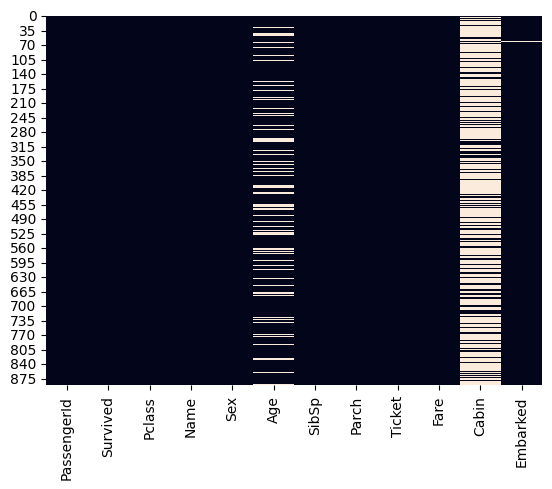

In [81]:
# Visualize missing values
sns.heatmap(train_data.isnull(), cbar=False)
plt.show()

In [82]:
# Print the age % of NaN values
age_nan_percent = train_data['Age'].isna().mean() * 100
print(f"Il y a {age_nan_percent:.2f}% d'âge qui manquent")

Il y a 19.87% d'âge qui manquent


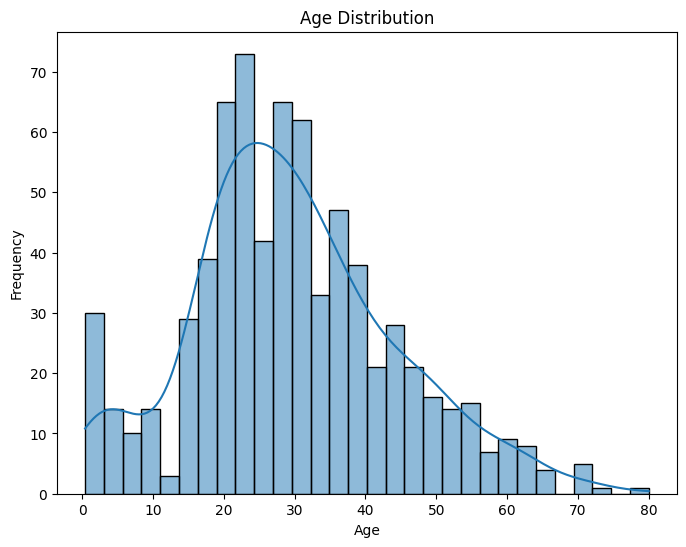

In [83]:
# Plot the histogram of the age column
plt.figure(figsize=(8, 6))
sns.histplot(train_data['Age'].dropna(), bins=30, kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

In [84]:
# Print the median and mean of the age column
age_mean = train_data['Age'].mean()
age_median = train_data['Age'].median()
print(f"Moyenne : {age_mean:.2f}")
print(f"Médiane : {age_median:.2f}")

Moyenne : 29.70
Médiane : 28.00


In [85]:
# Print the cabin % of NaN values
cabin_nan_percent = train_data['Cabin'].isna().mean() * 100
print(f"Il y a {cabin_nan_percent:.2f}% de Cabin qui manquent")

Il y a 77.10% de Cabin qui manquent


Distribution des passagers par port d'embarquement (C = Cherbourg, Q = Queenstown, S = Southampton):
Embarked
S    644
C    168
Q     77
Name: count, dtype: int64


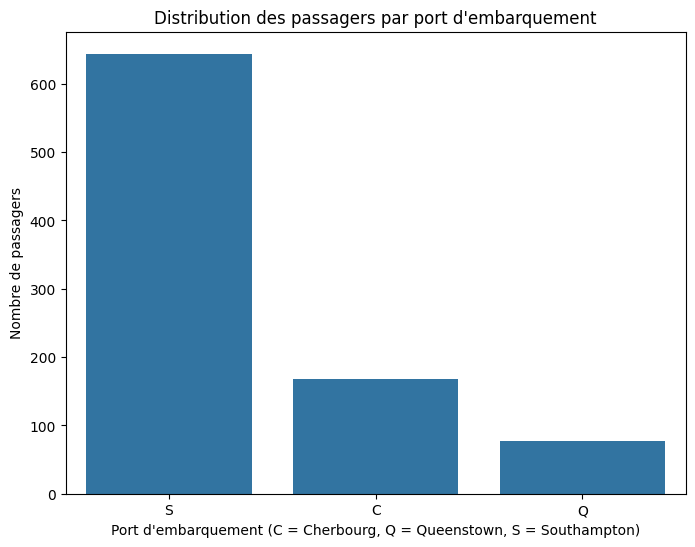

In [86]:
# Print the embarked distribution
embarked_distribution = train_data['Embarked'].value_counts()
print("Distribution des passagers par port d'embarquement (C = Cherbourg, Q = Queenstown, S = Southampton):")
print(embarked_distribution)

# Display the embarked distribution with a histogram
plt.figure(figsize=(8, 6))
sns.countplot(data=train_data, x='Embarked')
plt.title('Distribution des passagers par port d\'embarquement')
plt.xlabel('Port d\'embarquement (C = Cherbourg, Q = Queenstown, S = Southampton)')
plt.ylabel('Nombre de passagers')
plt.show()

In [87]:
# 1. Impute missing "Age" with the median (28)
train_data['Age'].fillna(28, inplace=True)
test_data['Age'].fillna(28, inplace=True)

# 2. Impute missing "Embarked" with the most common value (mode), which is 'S'
train_data['Embarked'].fillna(train_data['Embarked'].mode()[0], inplace=True)
test_data['Embarked'].fillna(test_data['Embarked'].mode()[0], inplace=True)

# 3. Drop the 'Cabin' column as it has too many missing values
train_data.drop(columns=['Cabin'], inplace=True)
test_data.drop(columns=['Cabin'], inplace=True)

# Verify the changes
print("Train Data after preprocessing:")
print(train_data.isnull().sum())  # Check for missing values

print("Test Data after preprocessing:")
print(test_data.isnull().sum())  # Check for missing values


Train Data after preprocessing:
PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64
Test Data after preprocessing:
PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           1
Embarked       0
dtype: int64


C:\Users\boula\AppData\Local\Temp\ipykernel_2704\1696696191.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['Age'].fillna(28, inplace=True)
C:\Users\boula\AppData\Local\Temp\ipykernel_2704\1696696191.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, wh

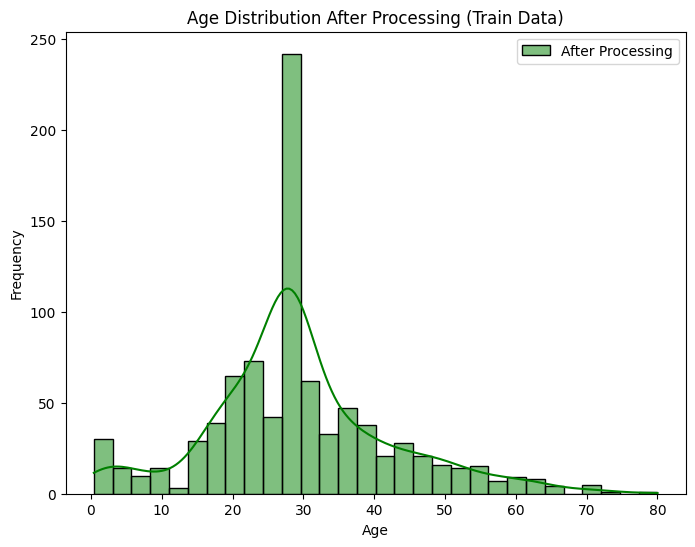

In [88]:
# Plot the histogram of the 'Age' column after processing
plt.figure(figsize=(8, 6))
sns.histplot(train_data['Age'], kde=True, color='green', label='After Processing')
plt.title('Age Distribution After Processing (Train Data)')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [89]:
# 1. Feature Engineering - Create the 'TravelAlone' feature
train_data['TravelAlone'] = (train_data['SibSp'] + train_data['Parch'] == 0).astype(int)
test_data['TravelAlone'] = (test_data['SibSp'] + test_data['Parch'] == 0).astype(int)

# 2. Handle Missing Values
train_data['Age'].fillna(28, inplace=True)  # Impute missing Age with median
test_data['Age'].fillna(28, inplace=True)   # Impute missing Age with median
train_data['Embarked'].fillna('S', inplace=True)  # Impute missing Embarked with 'S'
test_data['Embarked'].fillna('S', inplace=True)   # Impute missing Embarked with 'S'

# 3. Get Dummies for Categorical Features
train_data_encoded = pd.get_dummies(train_data, columns=['Sex', 'Embarked', 'Pclass'], drop_first=True)
test_data_encoded = pd.get_dummies(test_data, columns=['Sex', 'Embarked', 'Pclass'], drop_first=True)

# 4. Drop unnecessary columns
train_data_encoded.drop(columns=['Name', 'Ticket', 'Cabin'], inplace=True)
test_data_encoded.drop(columns=['Name', 'Ticket', 'Cabin'], inplace=True)

# 5. Print missing values
print('Missing values in train data:')
print(train_data_encoded.isnull().sum())
print('\nMissing values in test data:')
print(test_data_encoded.isnull().sum())

C:\Users\boula\AppData\Local\Temp\ipykernel_2704\1805877959.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['Age'].fillna(28, inplace=True)  # Impute missing Age with median
C:\Users\boula\AppData\Local\Temp\ipykernel_2704\1805877959.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always b

KeyError: "['Cabin'] not found in axis"

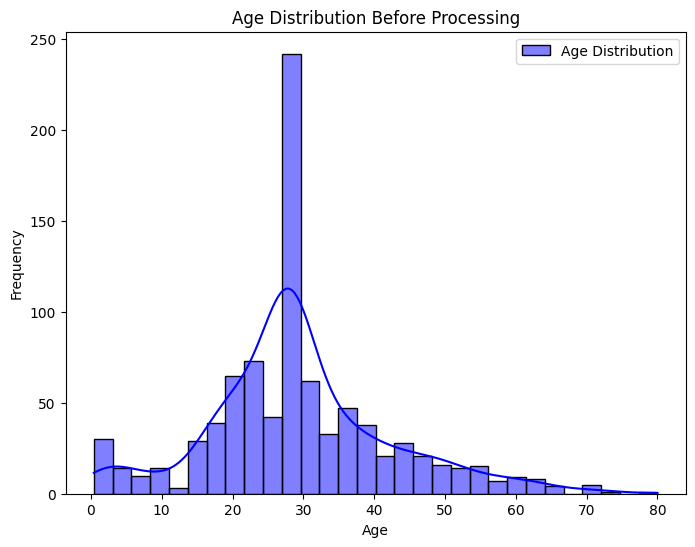

In [ ]:
# 6. Exploratory Data Analysis - Visualizations

# Age Distribution
plt.figure(figsize=(8, 6))
sns.histplot(train_data['Age'], kde=True, color='blue', label='Age Distribution')
plt.title('Age Distribution Before Processing')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend()
plt.show()


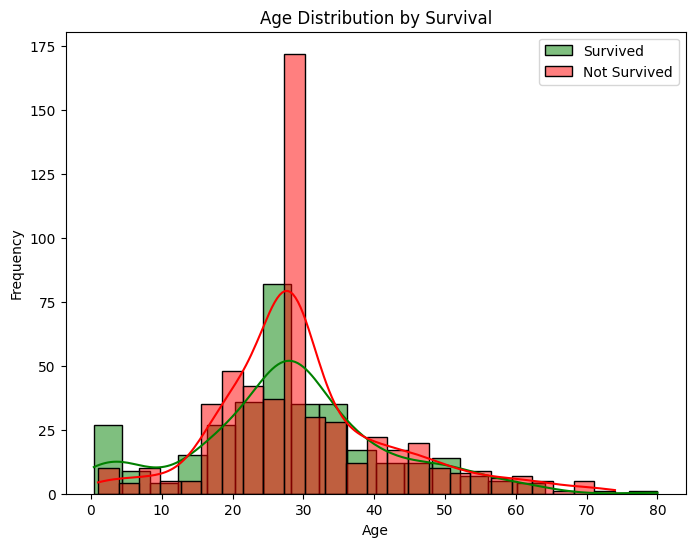

In [ ]:
# Add IsMinor variable (considered minor if under 16)
train_data_encoded['IsMinor'] = (train_data_encoded['Age'] < 16).astype(int)
test_data_encoded['IsMinor'] = (test_data_encoded['Age'] < 16).astype(int)

# Age Distribution Highlighting Survived
plt.figure(figsize=(8, 6))
sns.histplot(train_data_encoded[train_data_encoded['Survived'] == 1]['Age'], kde=True, color='green', label='Survived')
sns.histplot(train_data_encoded[train_data_encoded['Survived'] == 0]['Age'], kde=True, color='red', label='Not Survived')
plt.title('Age Distribution by Survival')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend()
plt.show()

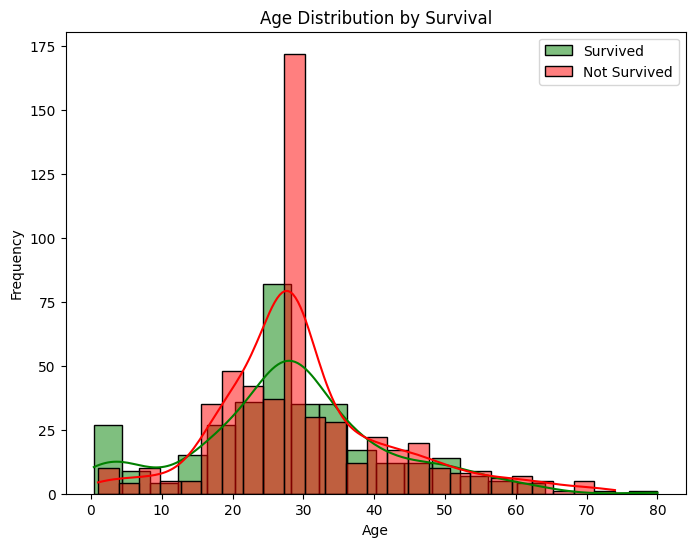

In [ ]:
# Add IsMinor variable (considered minor if under 16)
train_data_encoded['IsMinor'] = (train_data_encoded['Age'] < 16).astype(int)
test_data_encoded['IsMinor'] = (test_data_encoded['Age'] < 16).astype(int)

# Age Distribution Highlighting Survived
plt.figure(figsize=(8, 6))
sns.histplot(train_data_encoded[train_data_encoded['Survived'] == 1]['Age'], kde=True, color='green', label='Survived')
sns.histplot(train_data_encoded[train_data_encoded['Survived'] == 0]['Age'], kde=True, color='red', label='Not Survived')
plt.title('Age Distribution by Survival')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend()
plt.show()

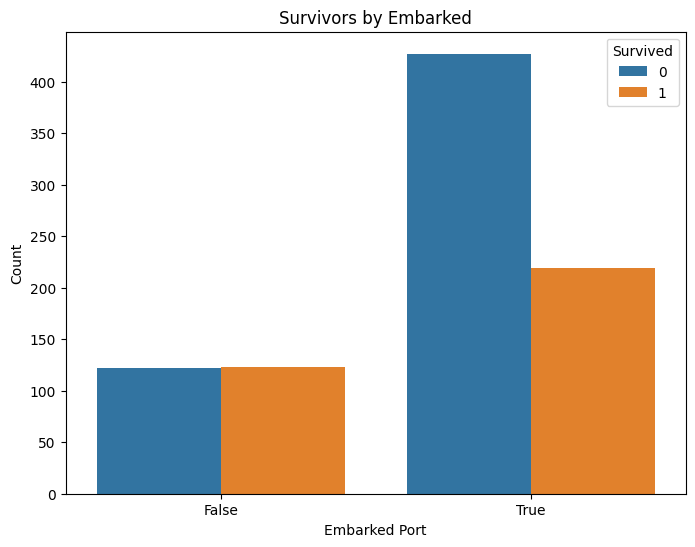

In [ ]:
# Survivors by Embarked
plt.figure(figsize=(8, 6))
sns.countplot(x='Embarked_S', hue='Survived', data=train_data_encoded)
plt.title('Survivors by Embarked')
plt.xlabel('Embarked Port')
plt.ylabel('Count')
plt.show()

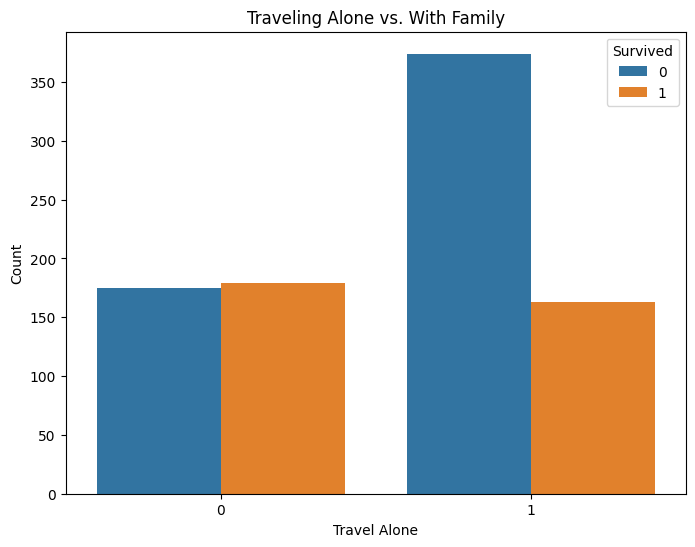

In [ ]:
# Traveling Alone vs. With Family
plt.figure(figsize=(8, 6))
sns.countplot(x='TravelAlone', hue='Survived', data=train_data_encoded)
plt.title('Traveling Alone vs. With Family')
plt.xlabel('Travel Alone')
plt.ylabel('Count')
plt.show()

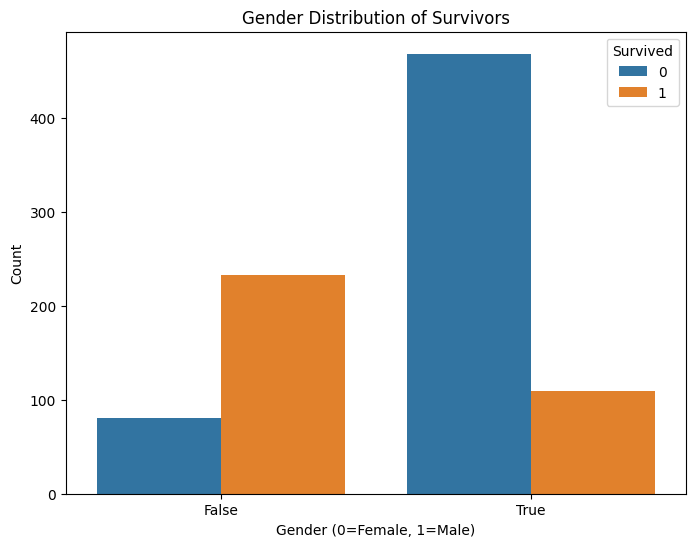

In [ ]:
# Gender Distribution of Survivors
plt.figure(figsize=(8, 6))
sns.countplot(x='Sex_male', hue='Survived', data=train_data_encoded)
plt.title('Gender Distribution of Survivors')
plt.xlabel('Gender (0=Female, 1=Male)')
plt.ylabel('Count')
plt.show()

In [ ]:
# 7. Logistic Regression with Feature Selection

# Define features and target variable
X_train = train_data_encoded.drop(columns=['Survived'])
y_train = train_data_encoded['Survived']
X_test = test_data_encoded.drop(columns=['Survived'])
y_test = test_data_encoded['Survived']

KeyError: "['Survived'] not found in axis"

In [ ]:
# Logistic Regression Model
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

# Recursive Feature Elimination (RFE) - Select 4 features
rfe = RFE(lr, n_features_to_select=4)
rfe.fit(X_train, y_train)
print(f'Selected features (4): {X_train.columns[rfe.support_]}')

ValueError: could not convert string to float: 'Braund, Mr. Owen Harris'

In [ ]:
# RFE with 8 selected features
rfe_8 = RFE(lr, n_features_to_select=8)
rfe_8.fit(X_train, y_train)
print(f'Selected features (8): {X_train.columns[rfe_8.support_]}')

ValueError: could not convert string to float: 'Braund, Mr. Owen Harris'

In [ ]:
# Feature ranking with RFECV
rfecv = RFECV(estimator=lr, step=1, cv=5, scoring='accuracy')
rfecv.fit(X_train, y_train)
print(f'Optimal number of features: {rfecv.n_features_}')
print(f'Selected features (RFECV): {X_train.columns[rfecv.support_]}')

ValueError: could not convert string to float: 'Braund, Mr. Owen Harris'

In [ ]:
# Plot the number of features vs. cross-validation scores
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.xlabel('Number of features')
plt.ylabel('Cross-validation score')
plt.title('Feature Selection with RFECV')
plt.show()

AttributeError: 'RFECV' object has no attribute 'grid_scores_'

<Figure size 800x600 with 0 Axes>

In [ ]:
# 8. Evaluation
X_train_selected = X_train[X_train.columns[rfecv.support_]]
X_test_selected = X_test[X_test.columns[rfecv.support_]]

lr.fit(X_train_selected, y_train)
y_pred = lr.predict(X_test_selected)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy with selected features: {accuracy:.2f}')

AttributeError: 'RFECV' object has no attribute 'support_'